# Autoencoder Test for Saddle-Free Optimizer

> Copyright 2019 Dave Fernandes. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
> http://www.apache.org/licenses/LICENSE-2.0
>  
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

## Description
This example trains an autoencoder on MNIST data using either the ADAM optimizer or the Saddle-Free (SF) method.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from SFOptimizer import SFOptimizer
from SFOptimizer import SFDamping
from mnist.dataset import train
from mnist.dataset import test

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

np.set_printoptions(suppress=True)

### Model
Create a layer with sigmoid activation. Weights have a sparse random initialization as per [Martens \(2010\)](http://www.cs.toronto.edu/~jmartens/docs/Deep_HessianFree.pdf).

In [2]:
var_list = []

def logistic_layer(layer_name, input_layer, hidden_units, n_random):
    initial_W = np.zeros((input_layer.shape[1], hidden_units))
    for i in range(hidden_units):
        column = np.zeros((input_layer.shape[1], 1))
        column[0:n_random,:] += np.random.randn(n_random, 1)
        np.random.shuffle(column)
        initial_W[:, i:i+1] = column
    
    with tf.name_scope('layer_' + layer_name):
        W = tf.get_variable('W_' + layer_name, initializer=tf.convert_to_tensor(initial_W, dtype=input_layer.dtype), use_resource=True)
        b = tf.get_variable('b_' + layer_name, [hidden_units], initializer=tf.zeros_initializer(), dtype=input_layer.dtype, use_resource=True)
        y = tf.sigmoid(tf.matmul(input_layer, W) + b)
    
    var_list.append(W)
    var_list.append(b)
    return W, b, y

Deep autoencoder network from [Hinton & Salakhutdinov \(2006\)](https://www.cs.toronto.edu/~hinton/science.pdf). This example is used as a standard test in several optimization papers.

In [3]:
def AE_model(x):
    n_inputs = 28*28
    n_hidden1 = 1000
    n_hidden2 = 500
    n_hidden3 = 250
    n_hidden4 = 30

    with tf.name_scope('dnn'):
        _, _, y1 = logistic_layer('1', x, n_hidden1, 15)
        _, _, y2 = logistic_layer('2', y1, n_hidden2, 15)
        _, _, y3 = logistic_layer('3', y2, n_hidden3, 15)
        
        W4, b4, _ = logistic_layer('4', y3, n_hidden4, 15)
        y4 = tf.matmul(y3, W4) + b4
        
        _, _, y5 = logistic_layer('5', y4, n_hidden3, 15)
        _, _, y6 = logistic_layer('6', y5, n_hidden2, 15)
        _, _, y7 = logistic_layer('7', y6, n_hidden1, 15)
        W8, b8, y_out = logistic_layer('8', y7, n_inputs, 15)
        y_logits = tf.matmul(y7, W8) + b8

    with tf.name_scope('loss'):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=y_logits)
        loss = tf.reduce_mean(cross_entropy, name='loss')
        error = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(x, y_out), axis=1))

    return loss, error

### Training Loop
Saves weights to data directory.

In [4]:
def MNIST_AE_test(use_SF, start_from_previous_run):
    # Loop hyper-parameters
    if use_SF:
        n_epochs = 30
        batch_size = 2000
        n_little_steps = 5
        batch_repeats = 2 * (n_little_steps + 1)
        print_interval = 1
    else:
        n_epochs = 3000
        batch_size = 200
        batch_repeats = 1
        print_interval = 100

    # Set up datasets and iterator
    mnist_dir = os.path.join(os.getcwd(), 'mnist')
    train_dataset = train(mnist_dir).batch(batch_size, drop_remainder=True)
    # Replicate each batch batch_repeats times
    train_dataset = train_dataset.flat_map(lambda x, y:
        tf.data.Dataset.zip((tf.data.Dataset.from_tensors(x).repeat(batch_repeats), tf.data.Dataset.from_tensors(y).repeat(batch_repeats))))
    train_dataset = train_dataset.repeat(1)
    
    test_dataset = test(mnist_dir).batch(100000)
    
    iter = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
    train_init_op = iter.make_initializer(train_dataset)
    test_init_op = iter.make_initializer(test_dataset)
    x, labels = iter.get_next()
    
    # Set up model
    loss, error = AE_model(x)
    
    model_filepath = os.path.join(os.getcwd(), 'data', 'ae_weights')
    saver = tf.train.Saver(var_list)
    
    # Construct optimizer
    if use_SF:
        # See SFOptimizer.py for options
        optimizer = SFOptimizer(var_list, krylov_dimension=64, damping_type=SFDamping.marquardt, dtype=x.dtype)
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss)

    print('Initializing...')
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    if start_from_previous_run:
        saver.restore(sess, model_filepath)
    
    if use_SF:
        print('Constructing graph...')
        big_train_op = optimizer.minimize(loss)
        little_train_op = optimizer.fixed_subspace_step()
        update_op = optimizer.update()
        reset_op = optimizer.reset_lambda()

    history = []
    t0 = time.perf_counter()
    
    print("Training...")
    for epoch in range(n_epochs):
        iteration = 0
        total_error = 0.0
        sess.run(train_init_op)
        
        while True:
            try:
                if use_SF:
                    # Reset the damping parameter
                    _ = sess.run(reset_op)

                    # Compute Krylov subspace and take one training step
                    initial_loss, initial_lambda, _ = sess.run([loss, optimizer.lambda_damp, big_train_op])
                    final_loss, error_train, rho, _ = sess.run([loss, error, optimizer.rho, update_op])

                    if iteration % print_interval == 0:
                        print('-- Epoch:', epoch + 1, ' Batch:', iteration + 1, '--')
                        print('    Loss_i:', initial_loss, 'Loss_f:', final_loss, 'rho', rho, 'lambda:', initial_lambda)

                    # Take up to 5 more steps without recomputing the Krylov subspace
                    for little_step in range(n_little_steps):
                        initial_loss, initial_lambda, _ = sess.run([loss, optimizer.lambda_damp, little_train_op])
                        final_loss, error_new, rho, _ = sess.run([loss, error, optimizer.rho, update_op])

                        if error_new < error_train:
                            error_train = error_new

                        if iteration % print_interval == 0:
                            print('    Loss_i:', initial_loss, 'Loss_f:', final_loss, 'rho', rho, 'lambda:', initial_lambda)
                else:
                    # Take a gradient descent step
                    _, initial_loss, error_train = sess.run([train_op, loss, error])

                    if iteration % print_interval == 0:
                        print('-- Epoch:', epoch + 1, ' Batch:', iteration + 1, '--')
                        print('    Loss:', initial_loss)

                history += [error_train]
                total_error += error_train

                if iteration % print_interval == 0:
                    print('    Train error:', error_train)
                iteration += 1
                
            except tf.errors.OutOfRangeError:
                break
            
        error_train = total_error / iteration
        sess.run(test_init_op)
        error_test = sess.run(error)

        t1 = time.perf_counter()
        dt = t1 - t0
        t0 = t1

        print('\n*** Epoch:', epoch + 1, 'Train error:', error_train, ' Test error:', error_test, ' Time:', dt, 'sec\n')
        save_path = saver.save(sess, model_filepath)
    
    sess.close()
    return history, optimizer.get_name()

* Train with `use_SF = False` to use the ADAM method, and with `use_SF = True` to use the Saddle-Free method.
* Train with `start_from_previous_run = False` to start from random initialization, and with `start_from_previous_run = True` to start from where you previously left off.

In [5]:
history, opt_name = MNIST_AE_test(use_SF = True, start_from_previous_run = False)

Initializing...
Constructing graph...
Training...
-- Epoch: 1  Batch: 1 --
    Loss_i: 1.1837842 Loss_f: 0.48032126 rho 0.5522539 lambda: 0.01
    Loss_i: 0.48032126 Loss_f: 0.95031184 rho -0.3754485 lambda: 0.001
    Loss_i: 0.48032126 Loss_f: 0.8683601 rho -0.36342376 lambda: 0.010000001
    Loss_i: 0.48032126 Loss_f: 0.6522206 rho -0.22235817 lambda: 0.10000001
    Loss_i: 0.48032126 Loss_f: 0.51418805 rho -0.001765631 lambda: 1.0000001
    Loss_i: 0.48032126 Loss_f: 0.48377502 rho -1.6991708e-05 lambda: 10.0
    Train error: 73.9782
-- Epoch: 1  Batch: 2 --
    Loss_i: 0.48446438 Loss_f: 1.7152041 rho -4.1843586 lambda: 0.01
    Loss_i: 0.48446438 Loss_f: 0.43459043 rho 0.13331443 lambda: 0.099999994
    Loss_i: 0.43459043 Loss_f: 0.78828263 rho -5.9407206 lambda: 0.099999994
    Loss_i: 0.43459043 Loss_f: 0.5065517 rho -0.19927923 lambda: 0.99999994
    Loss_i: 0.43459043 Loss_f: 0.44410688 rho -0.0020834892 lambda: 9.999999
    Loss_i: 0.43459043 Loss_f: 0.44410688 rho -0.0020834

Plot the error versus training step. For reference, the previous best training error obtained by a first order method was 1.0 \([Sutskever, _et al_., 2013](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf)\), and by the SF method was 0.57 \([Dauphin, _et al_., 2014](https://arxiv.org/abs/1406.2572)\).

No handles with labels found to put in legend.


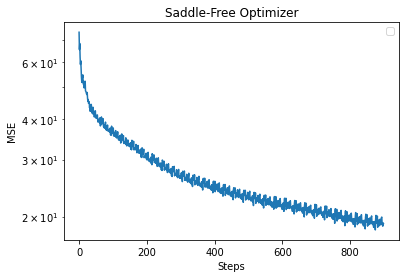

In [8]:
plt.plot(history)
plt.ylabel('MSE')
plt.yscale('log')
plt.xlabel('Steps')
#plt.xscale('log')
plt.title(opt_name + ' Optimizer')
plt.legend()
plt.savefig('1.png')
plt.show()